<a href="https://colab.research.google.com/github/ASALOGAN/MLPROJECTS/blob/main/01_PyTorch_Movie_Recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Version 2 of the PyTorch Movie Recommender System***

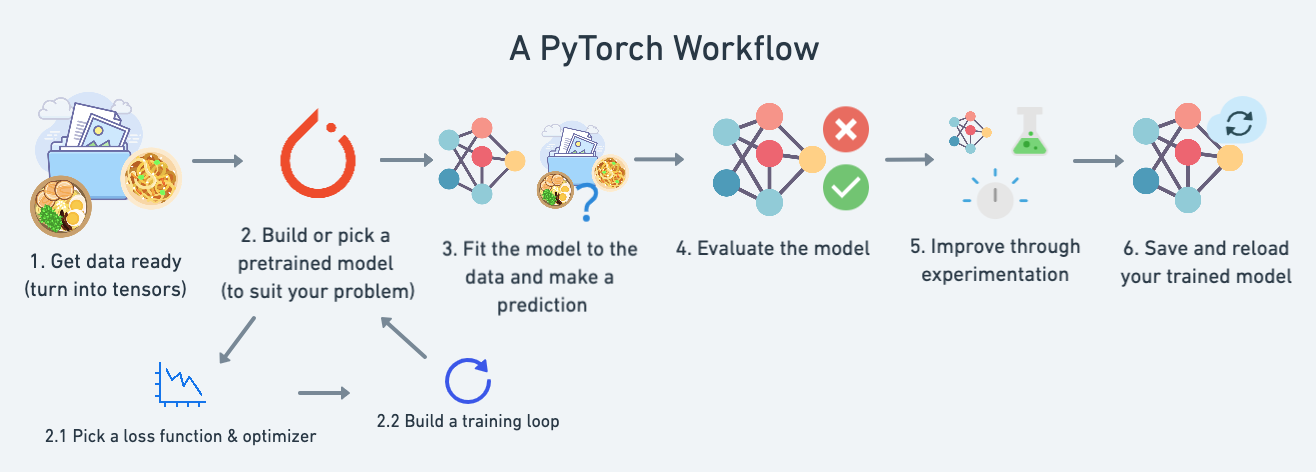

## ***1. Import all the necessary Libraries***

In [ ]:
# Import necessary libraries
import pandas as pd  # Import Pandas for data handling
import numpy as np  # Import NumPy for numerical operations
import torch  # Import PyTorch for deep learning
import torch.nn as nn  # Import neural network modules from PyTorch
import torch.optim as optim  # Import optimization algorithms from PyTorch
import matplotlib.pyplot as plt  # Import Matplotlib for plotting
from torch.utils.data import DataLoader, Dataset  # Import DataLoader and Dataset classes from PyTorch
from sklearn.model_selection import train_test_split  # Import train_test_split for data splitting
from sklearn import metrics, preprocessing  # Import metrics and preprocessing tools from scikit-learn

In [ ]:
print(f"Torch Version: {torch.__version__}")

Torch Version: 2.1.0+cu118


## ***2. Device Agnostic Code***

In [ ]:
# Check for GPU availability and set device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Print the device being used (GPU if available, otherwise CPU)
print(f'Using device: {device}')

Using device: cuda


## ***3. Data Preparation***

1.   **Loading the Dataset**
2.   **Reading the Dataset**
3.   **Data Encoding**



### ***3.1 Loading The Dataset***

In [ ]:
# Import necessary libraries for data loading and manipulation

from google.colab import drive  # Importing Google Colab's drive module to access files from Google Drive
from pathlib import Path  # Importing Path module from pathlib for handling file paths
import shutil  # Importing shutil for high-level file operations like copying, moving, and deleting files

In [ ]:
# Mount Google Drive to access files in Google Colab
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define paths for file directories

drive_path = Path('/content/drive/My Drive/')  # Root directory of Google Drive
movie_lens_path = drive_path / 'Movie_Lens'  # Directory within Google Drive for MovieLens data, modify folder name if needed
colab_data_path = Path('Data')  # Directory in the Colab environment for data storage

In [ ]:
# Check if 'Data' folder exists in Colab
for i in range(3):
  if not colab_data_path.exists():
    # Create 'Data' folder in Colab if it doesn't exist
    colab_data_path.mkdir(parents=True, exist_ok=True)
  else:
    # Check if 'Movie_Lens' folder exists within 'Data' folder
    if not (colab_data_path / 'Movie_Lens').exists():
        # Copy 'Movie_Lens' folder to 'Data' folder in Colab
        shutil.copytree(movie_lens_path, colab_data_path / 'Movie_Lens')
    else:
        print("'Movie_Lens' folder already exists in 'Data' folder.")
        break

'Movie_Lens' folder already exists in 'Data' folder.


### ***3.1 Reading the Dataset***

In [ ]:
# File path for ratings.csv within Movie_Lens folder
ratings_file_path = colab_data_path / 'Movie_Lens' / 'ratings.csv'

# Load ratings.csv into a Pandas DataFrame
ratings_data = pd.read_csv(ratings_file_path)

# Display the first few rows of the dataset
ratings_data.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


 ### ***3.3 Exploring The Dataset***

In [ ]:
# Display basic information about the dataset
print("Dataset information:")
print(ratings_data.info())

Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
None


In [ ]:
# Display descriptive statistics of numerical columns
print("\nDescriptive statistics:")
print(ratings_data.describe())


Descriptive statistics:
              userId        movieId         rating     timestamp
count  100836.000000  100836.000000  100836.000000  1.008360e+05
mean      326.127564   19435.295718       3.501557  1.205946e+09
std       182.618491   35530.987199       1.042529  2.162610e+08
min         1.000000       1.000000       0.500000  8.281246e+08
25%       177.000000    1199.000000       3.000000  1.019124e+09
50%       325.000000    2991.000000       3.500000  1.186087e+09
75%       477.000000    8122.000000       4.000000  1.435994e+09
max       610.000000  193609.000000       5.000000  1.537799e+09


In [ ]:
# Check for missing values
print("\nMissing values:")
print(ratings_data.isnull().sum())


Missing values:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


In [ ]:
# Display unique values and counts for specific columns
print("\nUnique values in 'userId' column:")
print(ratings_data['userId'].nunique())

print("\nUnique values in 'movieId' column:")
print(ratings_data['movieId'].nunique())

print("\nUnique values in 'rating' column:")
print(ratings_data['rating'].unique())


Unique values in 'userId' column:
610

Unique values in 'movieId' column:
9724

Unique values in 'rating' column:
[4.  5.  3.  2.  1.  4.5 3.5 2.5 0.5 1.5]


In [ ]:
# Shape of the ratings.csv file
print(f"Shape: {ratings_data.shape}")

Shape: (100836, 4)


### ***3.4: Encoding Movie and User ID***

In [ ]:
# Initialize LabelEncoders
user_encoder = preprocessing.LabelEncoder()
movie_encoder = preprocessing.LabelEncoder()

# Encode userId and movieId
ratings_data['userId'] = user_encoder.fit_transform(ratings_data['userId'])
ratings_data['movieId'] = movie_encoder.fit_transform(ratings_data['movieId'])

# Display encoded IDs
print("Encoded User IDs:")
print(ratings_data[['userId']].drop_duplicates().head())

print("\nEncoded Movie IDs:")
print(ratings_data[['movieId']].drop_duplicates().head())

Encoded User IDs:
     userId
0         0
232       1
261       2
300       3
516       4

Encoded Movie IDs:
   movieId
0        0
1        2
2        5
3       43
4       46


### ***3.5: Spliting Data into Train and Test***

In [ ]:
# Split the data into train and test sets using train_test_split function
Train, Test = train_test_split(
    ratings_data, test_size=0.1, random_state=42, stratify=ratings_data.rating.values
)

# Print lengths of Train and Test sets
print(f"Length of Train set: {len(Train)}")  # Print the length of the Train set
print(f"Length of Test set: {len(Test)}")  # Print the length of the Test set

# Print shapes of Train and Test sets
print(f"Train Set Shape: {Train.shape}")  # Print the shape of the Train set
print(f"Test Set Shape: {Test.shape}")  # Print the shape of the Test set

Length of Train set: 90752
Length of Test set: 10084
Train Set Shape: (90752, 4)
Test Set Shape: (10084, 4)


### ***3.6: Create Train & Test Dataset***

In [ ]:
class MovieDataset:
    def __init__(self, users, movies, ratings):
        # Initialize MovieDataset with users, movies, and ratings
        self.users = users  # List of user IDs
        self.movies = movies  # List of movie IDs
        self.ratings = ratings  # List of corresponding ratings

    # Implement len(movie_dataset)
    def __len__(self):
        # Return the total number of entries in the dataset (number of users)
        return len(self.users)

    # Implement movie_dataset[1]
    def __getitem__(self, item):
        # Get the data at a particular index 'item'

        users = self.users[item]  # Retrieve user ID at the given index
        movies = self.movies[item]  # Retrieve movie ID at the given index
        ratings = self.ratings[item]  # Retrieve rating at the given index

        # Return data in the form of a dictionary with tensors
        return {
            "users": torch.tensor(users, dtype=torch.long),  # Convert user ID to a PyTorch tensor
            "movies": torch.tensor(movies, dtype=torch.long),  # Convert movie ID to a PyTorch tensor
            "ratings": torch.tensor(ratings, dtype=torch.long),  # Convert rating to a PyTorch tensor
        }

In [ ]:
# Creating instances of MovieDataset for training and testing data
train_dataset = MovieDataset(Train['userId'].values, Train['movieId'].values, Train['rating'].values)
test_dataset = MovieDataset(Train['userId'].values, Train['movieId'].values, Train['rating'].values)

### ***3.7: Buding Train and Test Dataloader***

In [ ]:
# Define batch size for training and testing data
batch_size = 4

# Create DataLoader for training dataset
Train_loader = DataLoader(dataset=train_dataset,  # Use the train_dataset created earlier
                          batch_size=batch_size,  # Set the batch size for training
                          shuffle=True,  # Shuffle the training data for each epoch
                          num_workers=2)  # Number of subprocesses to use for data loading

# Create DataLoader for testing dataset
Test_loader = DataLoader(dataset=test_dataset,  # Use the test_dataset created earlier
                         batch_size=batch_size,  # Set the batch size for testing
                         shuffle=True,  # Shuffle the testing data for each epoch
                         num_workers=2)  # Number of subprocesses to use for data loading

## ***4. Building a Model***

In [ ]:
class MatrixFactorization(nn.Module):
  def __init__(self, num_users, num_movies):
    super(MatrixFactorization, self).__init__()

    # Trainable lookup matrix for shallow embedding vectors
    self.user_embed = nn.Embedding(num_users, 32)  # Embedding for users
    self.movie_embed = nn.Embedding(num_movies, 32)  # Embedding for movies

    # User, movie embedding concatenation followed by a linear layer
    self.out = nn.Linear(64, 1)  # Linear layer with input size 64 and output size 1

  def forward(self, users, movies, ratings=None):
    user_embeds = self.user_embed(users)  # Embedding lookup for users
    movie_embeds = self.movie_embed(movies)  # Embedding lookup for movies
    output = torch.cat([user_embeds, movie_embeds], dim=1)  # Concatenate user and movie embeddings

    output = self.out(output)  # Pass concatenated embeddings through the linear layer

    return output

## ***5. Initializing the Model***

In [ ]:
# Initialize the model
model_0 = MatrixFactorization(num_users=len(user_encoder.classes_),
                              num_movies=len(movie_encoder.classes_)).to(device)

model_0.parameters()

<generator object Module.parameters at 0x7f13a3f3c9e0>

## ***6. Setup Loss function, Optimizer and Scheduler***

In [ ]:
# Define the loss function (Mean Squared Error)
loss_function = nn.MSELoss()

# Define the optimizer
optimizer = optim.Adam(model_0.parameters())

# Define the learning rate scheduler (if needed)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.7)

### ***6.1 Visualizing the data passed through the model_0***

In [ ]:
# Length of num_users and num_movies
print(f"Number of users: {len(user_encoder.classes_)}")
print(f"Number of movies: {len(movie_encoder.classes_)}")

# Maximum movie ID
max_movie_id = ratings_data['movieId'].max()
print(f"Maximum movie ID: {max_movie_id}")

# Length of train_dataset
print(f"Length of train_dataset: {len(train_dataset)}")

Number of users: 610
Number of movies: 9724
Maximum movie ID: 9723
Length of train_dataset: 90752


## ***7. Manual Forward Pass***

### ***7.1 Setting Sample Data***

In [ ]:
# Select a sample from the train_loader
dataiter = iter(Train_loader)
sample = next(dataiter)

# Extract user IDs, movie IDs, and ratings from the sample
users = sample['users']  # Assuming 'users' is the key in the sample dict
movies = sample['movies']  # Assuming 'movies' is the key in the sample dict
ratings = sample['ratings']  # Assuming 'ratings' is the key in the sample dict

# Print the content of the sample
print(f"Users: {users}")
print(f"Users Size: {users.size()}")
print(f"Movies: {movies}")
print(f"Movies Size: {movies.size()}")
print(f"Ratings: {ratings}")
print(f"Ratings Size: {ratings.size()}")

Users: tensor([287, 606, 536,  22])
Users Size: torch.Size([4])
Movies: tensor([2708,  968, 8645,  918])
Movies Size: torch.Size([4])
Ratings: tensor([4, 3, 2, 3])
Ratings Size: torch.Size([4])


### ***7.1 Manual Forward Pass***

In [ ]:
# Initialize embeddings for users and movies with sizes based on the number of unique classes for each
user_embed = nn.Embedding(len(user_encoder.classes_), 32)  # Embedding for users with size 32
movie_embed = nn.Embedding(len(movie_encoder.classes_), 32)  # Embedding for movies with size 32
out = nn.Linear(64, 1)  # Linear layer with input size 64 and output size 1

# Obtain embeddings for user and movie IDs
user_embeds = user_embed(users)  # Lookup user embeddings based on user IDs
movie_embeds = movie_embed(movies)  # Lookup movie embeddings based on movie IDs

# Print intermediate results and output sizes for user and movie embeddings
print(f"User Embeddings:\n{user_embeds}")  # Print user embeddings
print(f"User Embeddings Size: {user_embeds.size()}")  # Print size of user embeddings

print(f"\nMovie Embeddings:\n{movie_embeds}")  # Print movie embeddings
print(f"Movie Embeddings Size: {movie_embeds.size()}")  # Print size of movie embeddings

# Concatenate user and movie embeddings along the specified dimension
output = torch.cat([user_embeds, movie_embeds], dim=1)  # Concatenate user and movie embeddings

# Print concatenated output and its size
print(f"\nConcatenated Output:\n{output}")  # Print concatenated output
print(f"Concatenated Output Size: {output.size()}")  # Print size of concatenated output

# Pass the concatenated output through the linear layer
output = out(output)  # Linear transformation of concatenated output

# Print the final output from the model
print(f"\nModel Output:\n {output}")  # Print the model output

User Embeddings:
tensor([[-0.4667,  0.8656,  0.0866,  1.6429, -1.2540,  0.7834,  0.8248,  1.8220,
          0.7901,  0.2697,  0.1516,  0.2692,  0.4072, -1.0894,  0.0559,  0.3471,
         -0.7629,  1.4371,  0.9623,  0.2972,  1.0520, -0.5041,  0.2849,  0.0072,
          0.8202, -0.8481, -0.6943,  0.4736, -1.7851, -0.2420,  0.7879,  1.5108],
        [ 1.4357, -0.2290, -1.1162, -1.0260,  1.0385, -0.0576, -1.8384, -0.5477,
          1.3974, -0.1553, -1.9449, -1.2607, -1.3501, -2.1151, -0.0739, -1.0800,
          4.1562,  0.7693, -0.2067,  0.6477,  0.8903,  1.7836,  0.6703, -1.4303,
         -1.6043, -0.0443, -0.3664,  0.2709,  1.2754, -0.4119, -1.1564, -0.3108],
        [ 0.9648,  0.6493, -0.2189, -0.0519, -0.3042, -0.4741,  1.1592, -0.5401,
          2.3942, -0.1621, -0.7174,  0.8696, -0.3304, -0.7074, -0.0357, -1.1530,
          0.2441, -0.5920, -0.6869,  0.9521, -0.3786,  0.9942,  0.7387, -0.2747,
         -0.5628,  0.9591,  0.6895,  1.0068, -1.4780,  0.0112,  0.4464, -1.4549],
        

In [ ]:
users = users.to(device)  # Move users tensor to the specified device (GPU or CPU)
movies = movies.to(device)  # Move movies tensor to the specified device (GPU or CPU)

with torch.no_grad():  # Context manager to temporarily disable gradient calculation
    model_output = model_0(users, movies)  # Get model output for users and movies
    print(f"model_output: {model_output}, size: {model_output.size()}")  # Print model output and its size

model_output: tensor([[ 0.8676],
        [-0.1482],
        [-0.2139],
        [ 0.3612]], device='cuda:0'), size: torch.Size([4, 1])


In [ ]:
print(f"Ratings:\n {ratings}")  # Print the original ratings tensor

# Reshape the ratings tensor to a 4x(-1) tensor (if possible)
print(f"{ratings.view(4, -1)}")

print(f"Model Output:\n {model_output}")  # Print the model's output tensor

# Calculate and print the difference between the sum of model output and the sum of ratings
print(f"\nDifference:\n {model_output.sum() - ratings.sum()}")

Ratings:
 tensor([4, 3, 2, 3])
tensor([[4],
        [3],
        [2],
        [3]])
Model Output:
 tensor([[ 0.8676],
        [-0.1482],
        [-0.2139],
        [ 0.3612]], device='cuda:0')

Difference:
 -11.133291244506836


## ***8. Train The Model***

In [ ]:
import time
start_time = time.time()  # Record the start time

epochs = 20  # Number of epochs for training
total_loss = 0  # Variable to track the total loss across iterations
plot_steps, print_steps = 5000, 5000  # Steps for printing and plotting loss
step_cnt = 0  # Counter to track steps during training
all_losses_list = []  # List to store all calculated losses

model_0.train()  # Set the model in training mode
for epoch_i in range(epochs):  # Loop through each epoch
    for i, train_data in enumerate(Train_loader):  # Iterate over the training data batches
        users = train_data["users"].to(device)  # Move user data to the appropriate device
        movies = train_data["movies"].to(device)  # Move movie data to the appropriate device
        output = model_0(users, movies)  # Forward pass: generate model predictions

        # Reshape the ratings to match the shape of model output (4x1)
        rating = train_data["ratings"].view(4, -1).to(torch.float32).to(device)

        loss = loss_function(output, rating)  # Calculate the loss
        total_loss = total_loss + loss.sum().item()  # Accumulate the total loss

        optimizer.zero_grad()  # Clear accumulated gradients
        loss.backward()  # Backpropagation: compute gradients
        optimizer.step()  # Update model parameters using gradients

        step_cnt = step_cnt + len(train_data["users"])  # Increment the step counter

        if step_cnt % print_steps == 0:  # Check if it's time to print the loss
            avg_loss = total_loss / (len(train_data["users"]) * print_steps)  # Calculate average loss
            print(f"epoch {epoch_i+1} loss at step: {step_cnt} is {avg_loss:.5f}")  # Print the average loss
            all_losses_list.append(avg_loss)  # Store average loss in the list
            total_loss = 0  # Reset total loss for the next set of steps

end_time = time.time()  # Record the end time

elapsed_time = end_time - start_time  # Calculate the elapsed time
print(f"Total time taken for training {epochs} Epochs: {elapsed_time} seconds")  # Print the elapsed time

epoch 1 loss at step: 5000 is 0.47153
epoch 1 loss at step: 10000 is 0.18192
epoch 1 loss at step: 15000 is 0.10660
epoch 1 loss at step: 20000 is 0.08539
epoch 1 loss at step: 25000 is 0.07252
epoch 1 loss at step: 30000 is 0.06761
epoch 1 loss at step: 35000 is 0.06546
epoch 1 loss at step: 40000 is 0.06274
epoch 1 loss at step: 45000 is 0.06005
epoch 1 loss at step: 50000 is 0.06254
epoch 1 loss at step: 55000 is 0.05873
epoch 1 loss at step: 60000 is 0.05973
epoch 1 loss at step: 65000 is 0.05919
epoch 1 loss at step: 70000 is 0.05738
epoch 1 loss at step: 75000 is 0.05632
epoch 1 loss at step: 80000 is 0.05664
epoch 1 loss at step: 85000 is 0.05840
epoch 1 loss at step: 90000 is 0.05430
epoch 2 loss at step: 95000 is 0.05564
epoch 2 loss at step: 100000 is 0.05449
epoch 2 loss at step: 105000 is 0.05251
epoch 2 loss at step: 110000 is 0.05015
epoch 2 loss at step: 115000 is 0.05511
epoch 2 loss at step: 120000 is 0.05443
epoch 2 loss at step: 125000 is 0.05160
epoch 2 loss at step

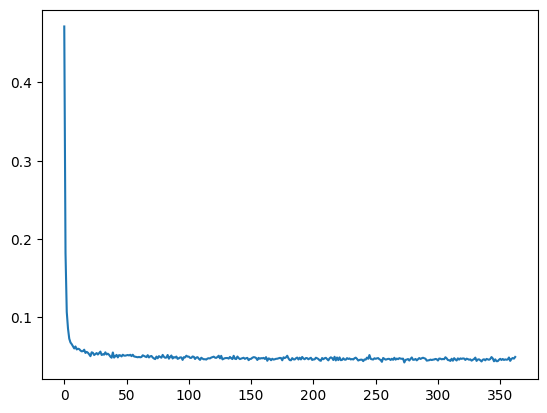

In [ ]:
plt.figure()
plt.plot(all_losses_list)
plt.show()

## ***9. Evaluate the Model With RMSE***

In [ ]:
from sklearn.metrics import mean_squared_error  # Importing necessary library

model_output_list = []  # List to collect model predictions
target_rating_list = []  # List to collect actual ratings

model_0.eval()  # Set the model to evaluation mode

with torch.no_grad():  # Disable gradient tracking for inference
    for i, batched_data in enumerate(Test_loader):  # Iterate over test data batches
        users = batched_data['users'].to(device)  # Move user data to the appropriate device
        movies = batched_data["movies"].to(device)  # Move movie data to the appropriate device
        ratings = batched_data["ratings"].to(device)  # Move rating data to the appropriate device

        model_output = model_0(users, movies)  # Obtain model predictions
        model_output_list.extend(model_output.cpu().numpy().flatten())  # Collect model predictions as a flat list

        target_rating_list.extend(ratings.cpu().numpy().flatten())  # Collect actual ratings as a flat list

# Calculate Root Mean Squared Error (RMSE) using sklearn's mean_squared_error function
RMSE = mean_squared_error(target_rating_list, model_output_list, squared=False)

print(f"Root Mean Squared Error (RMSE): {RMSE}")  # Print the computed RMSE

Root Mean Squared Error (RMSE): 0.8456197355151762


In [ ]:
for i in range(10):
  print(f"Diff: {model_output_list[i]-target_rating_list[i]}")

Diff: 0.329334020614624
Diff: -0.08476018905639648
Diff: -1.254202127456665
Diff: 0.41550731658935547
Diff: -0.9229879379272461
Diff: 0.10381555557250977
Diff: -0.4884226322174072
Diff: 1.1401405334472656
Diff: -0.6583156585693359
Diff: -0.7309539318084717


## ***10. Evaluate the Model Using Recall@K***

In [ ]:
from collections import defaultdict

# a dict that stores a list of predicted rating and actual rating pair for each user
User_Pred_Actual = defaultdict(list)

# iterate through the Test data to build the user-> [(y1, y1_hat), (y2, y2_hat)...]
with torch.no_grad():
  for i, batched_data in enumerate(Test_loader):
    users = batched_data['users'].to(device)
    movies = batched_data['movies'].to(device)
    ratings = batched_data['ratings'].to(device)

    model_output = model_0(users, movies)

    for i in range(len(users)):
      user_id = users[i].item()
      movie_id = movies[i].item()
      pred_rating = model_output[i][0].item()
      true_rating = ratings[i].item()

      print(f"User Id: {user_id} | Movie Id: {movie_id} | True Rating: {true_rating} | Prediction Rating: {pred_rating:.2f}")
      User_Pred_Actual[user_id].append((pred_rating, true_rating))

Streaming output truncated to the last 5000 lines.
User Id: 605 | Movie Id: 5044 | True Rating: 3 | Prediction Rating: 2.96
User Id: 605 | Movie Id: 490 | True Rating: 4 | Prediction Rating: 3.81
User Id: 473 | Movie Id: 4195 | True Rating: 2 | Prediction Rating: 3.10
User Id: 293 | Movie Id: 549 | True Rating: 1 | Prediction Rating: 2.45
User Id: 131 | Movie Id: 1234 | True Rating: 1 | Prediction Rating: 1.43
User Id: 598 | Movie Id: 2442 | True Rating: 2 | Prediction Rating: 1.83
User Id: 386 | Movie Id: 4391 | True Rating: 3 | Prediction Rating: 2.90
User Id: 109 | Movie Id: 520 | True Rating: 4 | Prediction Rating: 4.05
User Id: 476 | Movie Id: 2340 | True Rating: 3 | Prediction Rating: 4.13
User Id: 532 | Movie Id: 8200 | True Rating: 5 | Prediction Rating: 4.60
User Id: 473 | Movie Id: 2354 | True Rating: 4 | Prediction Rating: 3.48
User Id: 317 | Movie Id: 6997 | True Rating: 4 | Prediction Rating: 4.08
User Id: 607 | Movie Id: 4782 | True Rating: 4 | Prediction Rating: 3.12
Use

In [ ]:
with torch.no_grad():
  Precisions = dict()
  Recall = dict()

  K=100
  threshold = 3.5

  for UId, user_ratings in  User_Pred_Actual.items():
    # Sort user ratings by estimated value.
    user_ratings.sort(key=lambda x:x[0], reverse=True)

    n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

    n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:K])

    n_rel_and_n_rec_k = sum(
        ((true_r >= threshold) and (est >= threshold))
        for (est, true_r) in user_ratings[:K]
    )

    print(f"Used Id: {UId} | N Rel: {n_rel} | N Rec K: {n_rec_k} | N Rel & N Rec K: {n_rel_and_n_rec_k}")

    # Precision@K: Proportion of recommended items that are relevant
    # When n_rec_k is 0, Precision is undefined. We here set it to 0.

    Precisions[UId] = n_rel_and_n_rec_k / n_rec_k if n_rec_k != 0 else 0

    # Recall@K: Proportion of relevant items that are recommended
    # When n_rel is 0, Recall is undefined. We here set it to 0.

    Recall[UId] = n_rel_and_n_rec_k / n_rel if n_rel != 0 else 0


Used Id: 390 | N Rel: 212 | N Rec K: 100 | N Rel & N Rec K: 91
Used Id: 609 | N Rel: 544 | N Rec K: 100 | N Rel & N Rec K: 86
Used Id: 176 | N Rel: 319 | N Rec K: 100 | N Rel & N Rec K: 74
Used Id: 61 | N Rel: 254 | N Rec K: 100 | N Rel & N Rec K: 96
Used Id: 175 | N Rel: 23 | N Rec K: 29 | N Rel & N Rec K: 21
Used Id: 468 | N Rel: 237 | N Rec K: 100 | N Rel & N Rec K: 87
Used Id: 476 | N Rel: 351 | N Rec K: 100 | N Rel & N Rec K: 94
Used Id: 548 | N Rel: 12 | N Rec K: 19 | N Rel & N Rec K: 11
Used Id: 116 | N Rel: 55 | N Rec K: 84 | N Rel & N Rec K: 47
Used Id: 607 | N Rel: 253 | N Rec K: 100 | N Rel & N Rec K: 67
Used Id: 599 | N Rel: 175 | N Rec K: 99 | N Rel & N Rec K: 63
Used Id: 63 | N Rel: 238 | N Rec K: 100 | N Rel & N Rec K: 81
Used Id: 44 | N Rel: 250 | N Rec K: 100 | N Rel & N Rec K: 84
Used Id: 483 | N Rel: 165 | N Rec K: 100 | N Rel & N Rec K: 77
Used Id: 488 | N Rel: 184 | N Rec K: 74 | N Rel & N Rec K: 50
Used Id: 479 | N Rel: 280 | N Rec K: 100 | N Rel & N Rec K: 78
Use

In [ ]:
# Precision and recall can then be averaged over all users
print(f"Precision @ {K}: {(sum(prec for prec in Precisions.values()) / len(Precisions) * 100):.2f}%")
print(f"Recall @ {K}: {(sum(rec for rec in Recall.values()) / len(Recall) * 100):.2f}%")

Precision @ 100: 69.89%
Recall @ 100: 66.09%


In [ ]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "MRS.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/MRS.pth


In [ ]:
# Check the saved file path
!ls -l models/MRS.pth

-rw-r--r-- 1 root root 1324912 Nov 22 16:23 models/MRS.pth


In [ ]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model_0 = MatrixFactorization(len(user_encoder.classes_),len(movie_encoder.classes_))

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>